# Full Hybrid Sentiment + LSTM Stock Prediction Notebook

**End-to-end notebook**: downloads FNSPID & price data (via Kaggle/HuggingFace), merges & normalizes, computes hybrid sentiment (VADER + TextBlob + FinBERT), engineers features, trains a hybrid LSTM model (price sequence + sentiment branch), evaluates and plots results.

**Notes before running:**
- Run this in Google Colab (recommended) or local Jupyter with internet access.
- You must upload `kaggle.json` when prompted to download FNSPID via Kaggle.
- Downloading transformer models (FinBERT) requires internet and may take time.
- This notebook writes `final_merged_FNSPID.csv`, `hybrid_stock_model.pth`, and `scaler.save` to the working directory.

Run cells sequentially.

## 1 — Install required packages
Run the next cell once at the start. In Colab this will install dependencies.

In [13]:
# Install dependencies (run in Colab or local environment with internet)
# In Colab, pip install is fine. If you run locally, ensure PyTorch is installed for your CUDA/CPU.
import sys
!{sys.executable} -m pip install --upgrade pip
%pip install kaggle yfinance pandas numpy matplotlib seaborn scikit-learn torch torchvision torchaudio transformers nltk textblob vaderSentiment tweepy praw --quiet
print('Install finished; restart runtime if required.')

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Install finished; restart runtime if required.


In [2]:
# NLTK downloads
import nltk
nltk.download('vader_lexicon')
print('NLTK resources downloaded')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mushe\AppData\Roaming\nltk_data...


NLTK resources downloaded


## 2 — Kaggle authentication and dataset download
Upload `kaggle.json` when prompted. The cell downloads FNSPID and the price dataset (hosted on HuggingFace in this notebook).

In [ ]:
# Kaggle auth & dataset download (Colab)

import os, sys, time

# move to ~/.kaggle

print("Downloading FNSPID dataset from Kaggle (this may take a while)...")
!kaggle datasets download -d elsabetyemane/financial-news-and-stock-price-integration-dataset -q

print("Unzipping FNSPID...")
!unzip -q financial-news-and-stock-price-integration-dataset.zip -d fnspid_data

print("Downloading full price history (HuggingFace mirror)...")
!wget -q https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/main/Stock_price/full_history.zip

print("Unzipping prices...")
!unzip -q full_history.zip -d stock_prices

print("Datasets downloaded and unzipped: fnspid_data/  stock_prices/")

Dataset URL: https://www.kaggle.com/datasets/elsabetyemane/financial-news-and-stock-price-integration-dataset
License(s): unknown
Unzipping FNSPID...


'unzip' is not recognized as an internal or external command,
operable program or batch file.


Unzipping prices...


'wget' is not recognized as an internal or external command,
operable program or batch file.


Datasets downloaded and unzipped: fnspid_data/  stock_prices/


'unzip' is not recognized as an internal or external command,
operable program or batch file.


## 3 — Load, normalize & merge datasets
This cell reads price CSVs and FNSPID news CSV, normalizes dates and tickers, and merges into `final_df`.

In [11]:
# Load and normalize data
import pandas as pd, glob, os
from datetime import datetime, timezone


# Load all price CSVs from the unzipped folder
price_files = sorted(glob.glob('./stock_prices/full_history/*.csv'))
if not price_files:
    raise FileNotFoundError('No price files found in ./stock_prices/full_history/. Make sure the full_history.zip unzipped correctly.')

price_list = []
for f in price_files:
    df = pd.read_csv(f)
    # derive ticker from filename (some datasets name files with ticker)
    ticker = os.path.basename(f).replace('.csv','')
    df['stock'] = ticker
    price_list.append(df)

prices_df = pd.concat(price_list, ignore_index=True, sort=False)

# Load news CSV (path in FNSPID package)
news_path = 'fnspid_data/modularization-demo/data/raw_analyst_ratings.csv'
if not os.path.exists(news_path):
    # try to find any CSV inside fnspid_data
    candidates = glob.glob('fnspid_data/**/*.csv', recursive=True)
    if candidates:
        news_path = candidates[0]
    else:
        raise FileNotFoundError('No news CSV found in fnspid_data. Check the downloaded archive.')
news_df = pd.read_csv(news_path)

print('Loaded: prices rows =', len(prices_df), 'news rows =', len(news_df))

# Normalize dates: parse, coerce errors, convert to UTC then drop tz and normalize to midnight
prices_df['date'] = pd.to_datetime(prices_df['date'], utc=True, errors='coerce').dt.tz_localize(None).dt.normalize()
news_df['date'] = pd.to_datetime(news_df['date'], utc=True, errors='coerce').dt.tz_localize(None).dt.normalize()

# Clean tickers/stock column names (some files use different column names)
if 'stock' not in news_df.columns:
    # try common alternatives
    for c in ['stock_symbol','ticker','symbol','stock_symbol_y']:
        if c in news_df.columns:
            news_df = news_df.rename(columns={c:'stock'})
            break
# Ensure stock column exists
if 'stock' not in news_df.columns:
    raise KeyError('news_df does not contain a stock column. Available columns: ' + ','.join(news_df.columns))

prices_df['stock'] = prices_df['stock'].astype(str).str.strip()
news_df['stock'] = news_df['stock'].astype(str).str.strip()

# Quick debug print
print('Price sample dates/ticker:', prices_df['date'].iloc[0], prices_df['stock'].iloc[0])
print('News sample dates/ticker :', news_df['date'].iloc[0], news_df['stock'].iloc[0])

# Merge on date + stock
final_df = pd.merge(news_df, prices_df, on=['date','stock'], how='inner')
print('Merged final_df shape =', final_df.shape)
if final_df.empty:
    print('WARNING: Merged dataframe is empty — check date ranges and ticker naming.')
else:
    display(final_df.head())

Loaded: prices rows = 29677722 news rows = 1407328
Price sample dates/ticker: 2023-12-28 00:00:00 A
News sample dates/ticker : 2020-06-05 00:00:00 A
Merged final_df shape = (33898, 12)


,Unnamed: 0,headline,url,publisher,date,stock,volume,open,high,low,close,adj close
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05,A,2844700.0,92.129997,93.040001,90.089996,90.379997,88.321449
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03,A,1382500.0,90.650002,91.139999,90.260002,90.489998,88.428940
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26,A,3173400.0,86.230003,86.790001,85.639999,86.129997,84.168251
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22,A,5063100.0,85.000000,87.669998,84.199997,84.980003,83.044434
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22,A,5063100.0,85.000000,87.669998,84.199997,84.980003,83.044434


## 4 — Sentiment extraction (VADER + TextBlob + FinBERT)
This cell defines functions to compute hybrid sentiment per headline. FinBERT will download model weights the first time it's run (internet required).

In [ ]:
# Sentiment functions
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import numpy as np

# Load VADER
vader = SentimentIntensityAnalyzer()

# FinBERT model name (ProsusAI/finbert)
finbert_name = "ProsusAI/finbert"

print('Loading FinBERT tokenizer and model (this may take a few minutes)...')
tokenizer = AutoTokenizer.from_pretrained(finbert_name)
finbert = AutoModelForSequenceClassification.from_pretrained(finbert_name)
finbert.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
finbert.to(device)
print('FinBERT loaded on', device)

def finbert_sentiment(text, tokenizer=tokenizer, model=finbert, device=device):
    if not isinstance(text, str) or text.strip()=='':
        return 0.0
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=256).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    # map to scalar: positive - negative
    score = float(probs[0] - probs[1])
    return score

def hybrid_sentiment(text):
    # compute VADER, TextBlob, FinBERT and weighted hybrid
    try:
        v = vader.polarity_scores(text)['compound']
    except Exception:
        v = 0.0
    t = TextBlob(text).sentiment.polarity
    f = finbert_sentiment(text)
    return 0.2*v + 0.2*t + 0.6*f

# Quick demo (comment out in large runs)
print('Demo hybrid sentiment:', hybrid_sentiment('Company reports record profits and beats expectations'))

RuntimeError: duplicate registrations for aten.linspace.Tensor_Tensor

KeyboardInterrupt: 

## 5 — Aggregate sentiments per day, engineer features, and prepare dataset
This cell computes sentiment per headline, aggregates daily, merges with OHLCV, calculates moving averages and volatility, and shifts the target (next day close).

In [ ]:
# Compute sentiment per headline (this may take time on large datasets)
import tqdm
if 'final_df' not in globals():
    raise RuntimeError('final_df not found — run previous merge cell first.')

# Only keep necessary columns to save memory; adjust column names as needed
text_col = None
for c in ['headline','title','news_headline','text','body']:
    if c in final_df.columns:
        text_col = c
        break
if text_col is None:
    raise KeyError('No headline/title column found in merged data. Columns: ' + ','.join(final_df.columns))

print('Using text column:', text_col)

# To speed up, you may sample or limit the dataset during testing
sample_frac = 1.0  # set to 0.1 for quick debug
df_text = final_df[['date','stock', text_col]].copy()
df_text = df_text.rename(columns={text_col:'headline'})
if sample_frac < 1.0:
    df_text = df_text.sample(frac=sample_frac, random_state=42)

# Compute sentiment (use tqdm for progress)
sentiments = []
for h in tqdm.tqdm(df_text['headline'].astype(str).tolist(), desc='Sentiment'):
    sentiments.append(hybrid_sentiment(h))
df_text['sentiment'] = sentiments

# Aggregate to daily per stock
agg = df_text.groupby(['date','stock']).agg(
    sent_mean=('sentiment','mean'),
    sent_sum=('sentiment','sum'),
    sent_count=('sentiment','count')
).reset_index()

# Prepare price features (use OHLCV columns — adapt names if different)
prices = prices_df.copy()
# Ensure date normalization (in case)
prices['date'] = pd.to_datetime(prices['date']).dt.normalize()

# We'll compute daily features per stock and then merge
merged = pd.merge(prices, agg, on=['date','stock'], how='left')
merged['sent_mean'] = merged['sent_mean'].fillna(0.0)
merged['sent_sum'] = merged['sent_sum'].fillna(0.0)
merged['sent_count'] = merged['sent_count'].fillna(0)

# Sort and compute indicators per stock
merged = merged.sort_values(['stock','date']).reset_index(drop=True)
merged['return'] = merged.groupby('stock')['close'].pct_change()
merged['ma5'] = merged.groupby('stock')['close'].transform(lambda x: x.rolling(5).mean())
merged['ma10'] = merged.groupby('stock')['close'].transform(lambda x: x.rolling(10).mean())
merged['volatility'] = merged.groupby('stock')['return'].transform(lambda x: x.rolling(5).std())

# Drop rows with NaN indicators
merged = merged.dropna().reset_index(drop=True)

# Shift target (next-day close) per stock
merged['target'] = merged.groupby('stock')['close'].shift(-1)
merged = merged.dropna().reset_index(drop=True)

print('Prepared merged feature dataframe shape:', merged.shape)
display(merged.head())

Using text column: headline


Sentiment: 100%|██████████| 33898/33898 [23:20<00:00, 24.21it/s]
C:\Users\mushe\AppData\Local\Temp\ipykernel_14528\3752154905.py:50: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  merged['return'] = merged.groupby('stock')['close'].pct_change()


Prepared merged feature dataframe shape: (29599136, 16)


,date,volume,open,high,low,close,adj close,stock,sent_mean,sent_sum,sent_count,return,ma5,ma10,volatility,target
0,1999-12-02,3069800.0,31.294706,32.188843,30.892345,31.562946,27.145563,A,0.0,0.0,0.0,0.027656,30.409513,30.185980,0.011755,31.831188
1,1999-12-03,3041600.0,32.144135,32.680614,31.697067,31.831188,27.376266,A,0.0,0.0,0.0,0.008499,30.883405,30.221745,0.010619,32.725323
2,1999-12-06,2250700.0,32.367668,33.217094,32.322960,32.725323,28.145258,A,0.0,0.0,0.0,0.028090,31.402003,30.606223,0.011723,32.367668
3,1999-12-07,2215900.0,32.725323,32.904148,31.697067,32.367668,27.837664,A,0.0,0.0,0.0,-0.010929,31.840129,30.695637,0.016208,32.322960
4,1999-12-08,1887800.0,32.367668,32.635910,32.054722,32.322960,27.799208,A,0.0,0.0,0.0,-0.001381,32.162017,31.066702,0.017379,32.770027


In [16]:
# Save merged so we don’t lose it on Colab resets
merged.to_csv("merged_features_backup.csv", index=False)
print("💾 Saved merged_features_backup.csv")

💾 Saved merged_features_backup.csv


## 6 — Create sequences, scale features, and split into train/val/test per stock
This builds PyTorch datasets for training. You can adjust sequence length and batch size.

In [ ]:
# ---------------------------------------------
# FIXED STEP 6 — safely restores 'merged' if RAM reset
# ---------------------------------------------

import os
import pandas as pd

# Try restore merged if runtime lost variables
if 'merged' not in globals():
    print("❌ merged is not in memory — Colab probably reset RAM.")

    if os.path.exists("merged_features_backup.csv"):
        print("🔄 Loading merged_features_backup.csv ...")
        merged = pd.read_csv("merged_features_backup.csv")

        # Convert 'date' back to datetime and normalize again
        if 'date' in merged.columns:
            merged['date'] = pd.to_datetime(merged['date'], errors='coerce').dt.normalize()

        print("✅ merged successfully restored from backup CSV!")
    else:
        raise RuntimeError(
            "❌ merged is not in memory AND merged_features_backup.csv not found.\n"
            "→ RE-RUN Step 5 BEFORE running Step 6."
        )

print("Step 6 started — merged dataframe exists.")
print("merged shape:", merged.shape)
print("merged columns:", list(merged.columns))

# ---------------------------------------------
# Feature columns
# ---------------------------------------------
feature_cols = [
    'open','high','low','close','volume',
    'sent_mean','sent_sum','sent_count',
    'return','ma5','ma10','volatility'
]

# Column validation
missing = [c for c in feature_cols if c not in merged.columns]
if missing:
    raise KeyError(
        f"❌ Missing feature columns: {missing}\n"
        f"Available columns: {list(merged.columns)}"
    )

print("All required feature columns found ✓")

# ---------------------------------------------
# SCALE FEATURES
# ---------------------------------------------
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

merged_scaled = merged.copy()
merged_scaled[feature_cols + ['target']] = scaler.fit_transform(
    merged[feature_cols + ['target']]
)

print("Scaling complete ✓")

# ---------------------------------------------
# CREATE SEQUENCES
# ---------------------------------------------
import numpy as np

seq_len = 30
X_seqs = []
y_seqs = []

for stock in merged_scaled['stock'].unique():
    df_s = merged_scaled[merged_scaled['stock'] == stock].reset_index(drop=True)
    X_vals = df_s[feature_cols].values.astype('float32')
    y_vals = df_s['target'].values.astype('float32')

    for i in range(len(df_s) - seq_len):
        X_seqs.append(X_vals[i:i+seq_len])
        y_seqs.append(y_vals[i+seq_len])

X = np.array(X_seqs)
y = np.array(y_seqs)

print("Sequence creation complete ✓")
print("X shape:", X.shape, "  y shape:", y.shape)

# ---------------------------------------------
# TRAIN / VAL / TEST SPLIT
# ---------------------------------------------
n = len(X)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

import torch
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64

train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)),
                          batch_size=batch_size, shuffle=False)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val), torch.tensor(y_val)),
                        batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(y_test)),
                         batch_size=batch_size, shuffle=False)

print("Data loaders ready ✓")

❌ merged is not in memory — Colab probably reset RAM.
🔄 Loading merged_features_backup.csv ...


In [1]:
# ---------------------------------------------
# FIXED STEP 6 — PREDICTING RETURNS (Low RAM)
# ---------------------------------------------
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import gc

# 1. DEFINE DATA TYPES
feature_cols = [
    'open','high','low','close','volume',
    'sent_mean','sent_sum','sent_count',
    'return','ma5','ma10','volatility'
]

dtypes = {col: 'float32' for col in feature_cols}
dtypes['target'] = 'float32'
dtypes['stock'] = 'category' 

print("🔄 Loading data...")
if os.path.exists("merged_features_backup.csv"):
    needed_cols = feature_cols + ['target', 'stock', 'date']
    merged = pd.read_csv(
        "merged_features_backup.csv", 
        usecols=needed_cols, 
        dtype=dtypes,
        parse_dates=['date']
    )
    print(f"✅ Data Loaded. Shape: {merged.shape}")
else:
    raise RuntimeError("❌ merged_features_backup.csv not found.")

# ---------------------------------------------
# 2. SORT & FEATURE ENGINEERING (The New Part)
# ---------------------------------------------
print("⚙ Sorting and creating targets...")
merged.sort_values(by=['stock', 'date'], inplace=True)

# A. Calculate Returns (Input Feature)
# We use a global shift for speed, then fix the rows where stock changes
merged['return'] = merged['close'].pct_change()
# Fix boundary: If stock name changed from prev row, return is invalid (NaN)
mask_boundary = merged['stock'] != merged['stock'].shift(1)
merged.loc[mask_boundary, 'return'] = np.nan

# B. Calculate Target (Next Day's Return)
# Shift return column UP by 1 to predict tomorrow
merged['target'] = merged['return'].shift(-1)
# Fix boundary: If stock name changes in next row, target is invalid (NaN)
mask_boundary_next = merged['stock'] != merged['stock'].shift(-1)
merged.loc[mask_boundary_next, 'target'] = np.nan

# C. Drop Invalid Rows (First/Last rows of each stock)
original_len = len(merged)
merged.dropna(inplace=True)
print(f"   Dropped {original_len - len(merged)} boundary rows.")

# ---------------------------------------------
# 3. MANUAL IN-PLACE SCALING
# ---------------------------------------------
print("⚖ Scaling features in-place...")
# Scale Features
for col in feature_cols:
    _min = merged[col].min()
    _max = merged[col].max()
    _range = _max - _min
    
    if _range == 0:
        merged[col] = 0.0
    else:
        merged[col] -= _min
        merged[col] /= _range

# Scale Target (Returns)
# We MUST scale returns because they are small (e.g., 0.01) and negative
t_min = merged['target'].min()
t_max = merged['target'].max()
t_range = t_max - t_min

if t_range != 0:
    merged['target'] -= t_min
    merged['target'] /= t_range

scaler_info = {'min': t_min, 'range': t_range}
print(f"   Target Scaler Saved: Min={t_min:.4f}, Range={t_range:.4f}")

# ---------------------------------------------
# 4. PREPARE MATRIX
# ---------------------------------------------
print("✂ Generating sequences...")
seq_len = 30
group_sizes = merged.groupby('stock', sort=False, observed=True).size().values

all_valid_indices = []
current_ptr = 0

for size in group_sizes:
    if size > seq_len:
        end_ptr = current_ptr + size - seq_len
        indices = np.arange(current_ptr, end_ptr)
        all_valid_indices.append(indices)
    current_ptr += size

valid_start_indices = np.concatenate(all_valid_indices)

# Create Float32 Matrix
data_matrix = merged[feature_cols + ['target']].values 
print(f"   Matrix Shape: {data_matrix.shape}")

# Cleanup
del merged
gc.collect() 
print("✅ RAM cleared.")

# ---------------------------------------------
# 5. DATASET CLASS
# ---------------------------------------------
class StockTimeSeiresDataset(Dataset):
    def __init__(self, data_array, indices, seq_len):
        self.data = data_array
        self.indices = indices
        self.seq_len = seq_len

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        start_idx = self.indices[idx]
        # Input: 30 days of data
        x_seq = self.data[start_idx : start_idx + self.seq_len, :-1]
        # Target: Return of the 31st day
        y_val = self.data[start_idx + self.seq_len, -1]
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)

# Split
n = len(valid_start_indices)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

train_indices = valid_start_indices[:train_end]
val_indices = valid_start_indices[train_end:val_end]
test_indices = valid_start_indices[val_end:]

# Create Datasets
train_dataset = StockTimeSeiresDataset(data_matrix, train_indices, seq_len)
val_dataset = StockTimeSeiresDataset(data_matrix, val_indices, seq_len)
test_dataset = StockTimeSeiresDataset(data_matrix, test_indices, seq_len)

print(f"📊 Ready for Training (Target: Next Day Return)")

🔄 Loading data...
✅ Data Loaded. Shape: (29599136, 15)
⚙ Sorting and creating targets...
   Dropped 15211 boundary rows.
⚖ Scaling features in-place...
   Target Scaler Saved: Min=-1.0000, Range=inf
✂ Generating sequences...
   Matrix Shape: (29583925, 13)
✅ RAM cleared.
📊 Ready for Training (Target: Next Day Return)


## 7 — Hybrid LSTM model (price sequence + sentiment branch) and training loop

In [8]:
# ---------------------------------------------
# FIXED STEP 6 — REMOVES INFINITY & PREDICTS RETURNS
# ---------------------------------------------
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import gc

# 1. DEFINE DATA TYPES
feature_cols = [
    'open','high','low','close','volume',
    'sent_mean','sent_sum','sent_count',
    'return','ma5','ma10','volatility'
]

dtypes = {col: 'float32' for col in feature_cols}
dtypes['target'] = 'float32'
dtypes['stock'] = 'category' 

print("🔄 Loading data...")
if os.path.exists("merged_features_backup.csv"):
    needed_cols = feature_cols + ['target', 'stock', 'date']
    merged = pd.read_csv(
        "merged_features_backup.csv", 
        usecols=needed_cols, 
        dtype=dtypes,
        parse_dates=['date']
    )
    print(f"✅ Data Loaded. Shape: {merged.shape}")
else:
    raise RuntimeError("❌ merged_features_backup.csv not found.")

# ---------------------------------------------
# 2. SORT & FEATURE ENGINEERING
# ---------------------------------------------
print("⚙ Sorting and creating targets...")
merged.sort_values(by=['stock', 'date'], inplace=True)

# A. Calculate Returns
merged['return'] = merged['close'].pct_change()

# 🛡️ CRITICAL FIX: Replace Infinity with NaN so dropna() can remove it
merged.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fix boundary: If stock name changed from prev row, return is invalid
mask_boundary = merged['stock'] != merged['stock'].shift(1)
merged.loc[mask_boundary, 'return'] = np.nan

# B. Calculate Target (Next Day's Return)
merged['target'] = merged['return'].shift(-1)
mask_boundary_next = merged['stock'] != merged['stock'].shift(-1)
merged.loc[mask_boundary_next, 'target'] = np.nan

# C. Drop Invalid Rows
original_len = len(merged)
merged.dropna(inplace=True)
print(f"   Dropped {original_len - len(merged)} bad rows (NaNs + Infs).")

# ---------------------------------------------
# 3. MANUAL IN-PLACE SCALING
# ---------------------------------------------
print("⚖ Scaling features in-place...")
for col in feature_cols:
    _min = merged[col].min()
    _max = merged[col].max()
    _range = _max - _min
    
    if _range == 0:
        merged[col] = 0.0
    else:
        merged[col] -= _min
        merged[col] /= _range

# Scale Target (Returns)
t_min = merged['target'].min()
t_max = merged['target'].max()
t_range = t_max - t_min

if t_range != 0:
    merged['target'] -= t_min
    merged['target'] /= t_range

print(f"   Target Scaler Saved: Min={t_min:.4f}, Range={t_range:.4f}")

# ---------------------------------------------
# 4. PREPARE MATRIX & DATASET
# ---------------------------------------------
print("✂ Generating sequences...")
seq_len = 30
group_sizes = merged.groupby('stock', sort=False, observed=True).size().values

all_valid_indices = []
current_ptr = 0

for size in group_sizes:
    if size > seq_len:
        end_ptr = current_ptr + size - seq_len
        indices = np.arange(current_ptr, end_ptr)
        all_valid_indices.append(indices)
    current_ptr += size

valid_start_indices = np.concatenate(all_valid_indices)

data_matrix = merged[feature_cols + ['target']].values 
del merged
gc.collect() 

# Dataset Class
class StockTimeSeiresDataset(Dataset):
    def __init__(self, data_array, indices, seq_len):
        self.data = data_array
        self.indices = indices
        self.seq_len = seq_len

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        start_idx = self.indices[idx]
        x_seq = self.data[start_idx : start_idx + self.seq_len, :-1]
        y_val = self.data[start_idx + self.seq_len, -1]
        # 🛡️ Safety Clamp: Even if scaling failed, force values to be safe
        x_seq = np.nan_to_num(x_seq, nan=0.0, posinf=1.0, neginf=0.0)
        y_val = np.nan_to_num(y_val, nan=0.0, posinf=1.0, neginf=0.0)
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)

# Split
n = len(valid_start_indices)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

train_indices = valid_start_indices[:train_end]
val_indices = valid_start_indices[train_end:val_end]
test_indices = valid_start_indices[val_end:]

train_dataset = StockTimeSeiresDataset(data_matrix, train_indices, seq_len)
val_dataset = StockTimeSeiresDataset(data_matrix, val_indices, seq_len)
test_dataset = StockTimeSeiresDataset(data_matrix, test_indices, seq_len)

print(f"📊 Ready for Training.")

🔄 Loading data...
✅ Data Loaded. Shape: (29599136, 15)
⚙ Sorting and creating targets...
   Dropped 15245 bad rows (NaNs + Infs).
⚖ Scaling features in-place...
   Target Scaler Saved: Min=-1.0000, Range=3018436.5000
✂ Generating sequences...
📊 Ready for Training.


In [20]:
# ---------------------------------------------
# FIXED STEP 6 — OUTLIER CLIPPING + CORRECT TARGET
# ---------------------------------------------
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import gc

# 1. DEFINE DATA TYPES
feature_cols = [
    'open','high','low','close','volume',
    'sent_mean','sent_sum','sent_count',
    'return','ma5','ma10','volatility'
]

dtypes = {col: 'float32' for col in feature_cols}
dtypes['target'] = 'float32'
dtypes['stock'] = 'category' 

print("🔄 Loading data...")
if os.path.exists("merged_features_backup.csv"):
    needed_cols = feature_cols + ['target', 'stock', 'date']
    merged = pd.read_csv(
        "merged_features_backup.csv", 
        usecols=needed_cols, 
        dtype=dtypes,
        parse_dates=['date']
    )
    print(f"✅ Data Loaded. Shape: {merged.shape}")
else:
    raise RuntimeError("❌ merged_features_backup.csv not found.")

# ---------------------------------------------
# 2. CALCULATE RETURNS & CLIP OUTLIERS
# ---------------------------------------------
print("⚙ Processing Returns...")
merged.sort_values(by=['stock', 'date'], inplace=True)

# Calculate Returns
merged['return'] = merged['close'].pct_change()

# 🛡️ FIX 1: CLIP OUTLIERS (The 0.000 fix)
# Cap returns at +/- 30% to prevent scaler destruction
merged['return'] = merged['return'].clip(lower=-0.3, upper=0.3)

# Replace Inf/NaN
merged.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fix boundary (stock changes)
mask_boundary = merged['stock'] != merged['stock'].shift(1)
merged.loc[mask_boundary, 'return'] = np.nan

# Create Target (Next Day Return)
merged['target'] = merged['return'].shift(-1)
mask_boundary_next = merged['stock'] != merged['stock'].shift(-1)
merged.loc[mask_boundary_next, 'target'] = np.nan

# Drop bad rows
merged.dropna(inplace=True)

# ---------------------------------------------
# 3. MANUAL SCALING
# ---------------------------------------------
print("⚖ Scaling features...")
for col in feature_cols:
    _min = merged[col].min()
    _max = merged[col].max()
    _range = _max - _min
    
    if _range <= 1e-9: # Prevent div/0
        merged[col] = 0.0
    else:
        merged[col] -= _min
        merged[col] /= _range

# Scale Target
t_min = merged['target'].min()
t_max = merged['target'].max()
t_range = t_max - t_min

if t_range > 1e-9:
    merged['target'] -= t_min
    merged['target'] /= t_range

print(f"   Target Scaler: Min={t_min:.4f}, Range={t_range:.4f}")
# If Range is still huge, we know there's an issue, but clipping should fix it.

# ---------------------------------------------
# 4. PREPARE DATASET
# ---------------------------------------------
print("✂ Generating sequences...")
seq_len = 30
group_sizes = merged.groupby('stock', sort=False, observed=True).size().values

all_valid_indices = []
current_ptr = 0

for size in group_sizes:
    if size > seq_len:
        # We need sequence + 1 target, so end is size - seq_len
        end_ptr = current_ptr + size - seq_len
        indices = np.arange(current_ptr, end_ptr)
        all_valid_indices.append(indices)
    current_ptr += size

valid_start_indices = np.concatenate(all_valid_indices)
data_matrix = merged[feature_cols + ['target']].values 

del merged
gc.collect() 

# ---------------------------------------------
# 5. FIXED DATASET CLASS (Fixing Index Logic)
# ---------------------------------------------
class StockTimeSeiresDataset(Dataset):
    def __init__(self, data_array, indices, seq_len):
        self.data = data_array
        self.indices = indices
        self.seq_len = seq_len

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        start_idx = self.indices[idx]
        
        # Input: Rows 0 to 29 (30 days)
        x_seq = self.data[start_idx : start_idx + self.seq_len, :-1]
        
        # 🛡️ FIX 2: TARGET INDEXING
        # Target for "Tomorrow" is stored in the 'target' column of the LAST input row
        # (Since merged['target'] at row i contains return of i+1)
        target_row_idx = start_idx + self.seq_len - 1
        y_val = self.data[target_row_idx, -1]
        
        x_seq = np.nan_to_num(x_seq, nan=0.0)
        y_val = np.nan_to_num(y_val, nan=0.0)
        
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)

# Splits & Loaders
n = len(valid_start_indices)
train_end = int(n * 0.8)
val_end = int(n * 0.9)
train_indices = valid_start_indices[:train_end]
val_indices = valid_start_indices[train_end:val_end]
test_indices = valid_start_indices[val_end:]

train_dataset = StockTimeSeiresDataset(data_matrix, train_indices, seq_len)
val_dataset = StockTimeSeiresDataset(data_matrix, val_indices, seq_len)
test_dataset = StockTimeSeiresDataset(data_matrix, test_indices, seq_len)

print("✅ Data Fixed & Ready.")

🔄 Loading data...
✅ Data Loaded. Shape: (29599136, 15)
⚙ Processing Returns...
⚖ Scaling features...
   Target Scaler: Min=-0.3000, Range=0.6000
✂ Generating sequences...
✅ Data Fixed & Ready.


In [21]:
# Check for NaNs or Infs in the tensors
print("Checking for bad data...")
x_sample, y_sample = next(iter(train_loader))

if torch.isnan(x_sample).any() or torch.isinf(x_sample).any():
    print("❌ ERROR: Input features (X) contain NaNs or Infs!")
else:
    print("✅ Inputs look clean.")

if torch.isnan(y_sample).any() or torch.isinf(y_sample).any():
    print("❌ ERROR: Targets (Y) contain NaNs or Infs!")
else:
    print("✅ Targets look clean.")

Checking for bad data...
✅ Inputs look clean.
✅ Targets look clean.


In [22]:
import torch
import multiprocessing
from torch.utils.data import DataLoader

# CONFIGURATION
BATCH_SIZE = 2048
NUM_WORKERS = 4    # Safe for Linux
PIN_MEMORY = True

print("⚙ Creating DataLoaders...")

# Create the loaders from the datasets you made in Step 6
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=True,
    prefetch_factor=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=True,
    prefetch_factor=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

print(f"✅ DataLoaders created successfully.")
print(f"   Train Batches: {len(train_loader)}")

⚙ Creating DataLoaders...
✅ DataLoaders created successfully.
   Train Batches: 11468


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import multiprocessing
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler # Mixed Precision

# ==========================================
# 1. CONFIGURATION (Linux + RTX 3050 Optimized)
# ==========================================
BATCH_SIZE = 2048  # Large batch size for 23.5M rows
# Use 4-6 workers on Linux. 
NUM_WORKERS = 6    
PIN_MEMORY = True  

print(f"⚙ config: Batch Size={BATCH_SIZE}, Workers={NUM_WORKERS}, Device={torch.cuda.get_device_name(0)}")

# ==========================================
# 2. DATALOADERS
# ==========================================
# NOTE: This assumes 'train_dataset', 'val_dataset', 'test_dataset' 
# are already created in your previous cells.

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS, 
    pin_memory=PIN_MEMORY,
    persistent_workers=True, 
    prefetch_factor=4
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS, 
    pin_memory=PIN_MEMORY,
    persistent_workers=True,
    prefetch_factor=2
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS, 
    pin_memory=PIN_MEMORY
)

# ==========================================
# 3. MODEL DEFINITION
# ==========================================
class HybridModel(nn.Module):
    def __init__(self, num_features, lstm_hidden=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=lstm_hidden, batch_first=True)
        self.sent_fc = nn.Sequential(
            nn.Linear(num_features, 32),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.final = nn.Sequential(
            nn.Linear(lstm_hidden + 32, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last = lstm_out[:, -1, :] 
        sent = self.sent_fc(x[:, -1, :]) 
        cat = torch.cat([last, sent], dim=1)
        out = self.final(cat)
        return out.squeeze(1)

# ==========================================
# 4. CUSTOM LOSS FUNCTION (Directional Penalty)
# ==========================================
class DirectionalMSELoss(nn.Module):
    def __init__(self, alpha=5.0):
        super().__init__()
        self.mse = nn.MSELoss()
        self.alpha = alpha # Penalty weight for wrong direction

    def forward(self, pred, actual):
        loss_mse = self.mse(pred, actual)
        
        # Directional Penalty:
        # sign_match > 0 if signs match (e.g. + * + or - * -)
        # sign_match < 0 if signs differ (e.g. + * -)
        sign_match = torch.sign(pred) * torch.sign(actual)
        
        # Penalize only where signs differ
        penalty = torch.mean(torch.relu(-sign_match) * torch.abs(pred - actual))
        
        return loss_mse + (self.alpha * penalty)

# ==========================================
# 5. SETUP & COMPILE
# ==========================================
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize model
model = HybridModel(num_features=len(feature_cols), lstm_hidden=64).to(device)

# Optimization: Compile model (PyTorch 2.0+)
try:
    print("Attempting to compile model with torch.compile...")
    model = torch.compile(model)
    print("✔ Model compiled successfully.")
except Exception as e:
    print(f"⚠ Skipping torch.compile: {e}")

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ⚠️ CHANGED: Use Directional Loss instead of standard MSE
criterion = DirectionalMSELoss(alpha=5.0) 

scaler = GradScaler() 

# ==========================================
# 6. TRAINING LOOP
# ==========================================
# ==========================================
# STABLE TRAINING LOOP (Fixes NaN)
# ==========================================
import torch.nn.utils as utils # For clipping

# 1. Reset Model & Optimizer (Start Fresh)
model = HybridModel(num_features=len(feature_cols), lstm_hidden=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4) # ⬇️ Lower LR to 0.0001
criterion = DirectionalMSELoss(alpha=1.0) # ⬇️ Lower alpha slightly for stability

# 2. Training Loop
best_val = float('inf')
patience = 0
max_patience = 5
n_epochs = 25

print("\n🚀 Starting Stabilized Training...")

for epoch in range(n_epochs):
    print(f"\n🔵 Epoch {epoch+1}/{n_epochs}")

    # Training
    model.train()
    train_losses = []
    train_loader_tqdm = tqdm(train_loader, desc="Training")

    for i, (xb, yb) in enumerate(train_loader_tqdm):
        xb = xb.to(device).float() # No Mixed Precision
        yb = yb.to(device).float()
        
        optimizer.zero_grad()

        # Standard Forward Pass (No autocast)
        preds = model(xb)
        loss = criterion(preds, yb)

        loss.backward()
        
        # 🛡️ KEY FIX: Clip Gradients to prevent explosion
        utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        loss_val = loss.item()
        
        # Check if loss turned to NaN during training
        if math.isnan(loss_val):
            print(f"❌ NaN detected at batch {i}! Stopping.")
            break
            
        train_losses.append(loss_val)
        
        if i % 20 == 0:
            train_loader_tqdm.set_postfix({"loss": f"{loss_val:.6f}"})

    if math.isnan(loss_val): break # Stop epoch if NaN

    # Validation
    model.eval()
    val_losses = []
    
    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc="Validating", leave=False):
            xb = xb.to(device).float()
            yb = yb.to(device).float()
            
            preds = model(xb)
            loss = criterion(preds, yb)
            val_losses.append(loss.item())

    train_loss = sum(train_losses) / len(train_losses)
    val_loss = sum(val_losses) / len(val_losses)
    
    print(f"✔ Train Loss: {train_loss:.6f} | ✔ Val Loss: {val_loss:.6f}")

    # Early stopping
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), 'best_hybrid_model.pth')
        print(f"  ⭐ New best model saved!")
        patience = 0
    else:
        patience += 1
        print(f"  ⏳ No improvement. Patience: {patience}/{max_patience}")
        if patience >= max_patience:
            print("⛔ Early stopping.")
            break

/tmp/ipykernel_25806/1216640230.py:123: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


⚙ config: Batch Size=2048, Workers=6, Device=NVIDIA GeForce RTX 3050 Laptop GPU
Attempting to compile model with torch.compile...
✔ Model compiled successfully.

🚀 Starting Stabilized Training...

🔵 Epoch 1/25


Training: 100%|████████████| 11468/11468 [02:38<00:00, 72.49it/s, loss=0.002899]
                                                                                

✔ Train Loss: 0.005223 | ✔ Val Loss: 0.003066
  ⭐ New best model saved!

🔵 Epoch 2/25


Training: 100%|████████████| 11468/11468 [02:41<00:00, 70.85it/s, loss=0.003444]
                                                                                

✔ Train Loss: 0.003093 | ✔ Val Loss: 0.003064
  ⭐ New best model saved!

🔵 Epoch 3/25


Training: 100%|████████████| 11468/11468 [02:42<00:00, 70.55it/s, loss=0.002740]
                                                                                

✔ Train Loss: 0.003090 | ✔ Val Loss: 0.003070
  ⏳ No improvement. Patience: 1/5

🔵 Epoch 4/25


Training: 100%|████████████| 11468/11468 [02:37<00:00, 72.81it/s, loss=0.003243]
                                                                                

✔ Train Loss: 0.003088 | ✔ Val Loss: 0.003073
  ⏳ No improvement. Patience: 2/5

🔵 Epoch 5/25


Training: 100%|████████████| 11468/11468 [02:40<00:00, 71.67it/s, loss=0.003314]
                                                                                

✔ Train Loss: 0.003086 | ✔ Val Loss: 0.003070
  ⏳ No improvement. Patience: 3/5

🔵 Epoch 6/25


Training: 100%|████████████| 11468/11468 [02:39<00:00, 71.88it/s, loss=0.003270]
                                                                                

✔ Train Loss: 0.003085 | ✔ Val Loss: 0.003078
  ⏳ No improvement. Patience: 4/5

🔵 Epoch 7/25


Training: 100%|████████████| 11468/11468 [02:38<00:00, 72.33it/s, loss=0.003376]
                                                                                

✔ Train Loss: 0.003083 | ✔ Val Loss: 0.003079
  ⏳ No improvement. Patience: 5/5
⛔ Early stopping.


## 8 — Evaluate on test set and plot predictions vs actuals

In [25]:
import numpy as np

# 1. Inspect the Scaler
print("--- 🔍 DEBUGGING SCALER ---")
print(f"Scaler Min:   {scaler_info.get('min')}")
print(f"Scaler Range: {scaler_info.get('range')}")

if scaler_info['range'] == 0 or np.isnan(scaler_info['range']):
    print("❌ CRITICAL ERROR: Scaler Range is 0 or NaN.")
    print("   This makes all 'Un-scaled' values identical (likely 0 or NaN).")
    print("   This explains the 99% accuracy (0 == 0).")

# 2. Inspect Raw Model Outputs (Before Un-scaling)
print("\n--- 🔍 DEBUGGING RAW OUTPUTS ---")
model.eval()
x_batch, y_batch = next(iter(val_loader))

with torch.no_grad():
    raw_preds = model(x_batch.to(device).float()).cpu().numpy()
    raw_actuals = y_batch.numpy()

print(f"Raw Preds Sample (First 5): {raw_preds[:5].flatten()}")
print(f"Raw Acts  Sample (First 5): {raw_actuals[:5].flatten()}")

# Check if they are constant
if np.std(raw_preds) < 1e-6:
    print("⚠ MODEL COLLAPSE: The model is predicting the same constant value for everything.")
if np.std(raw_actuals) < 1e-6:
    print("⚠ TARGET COLLAPSE: The validation targets are all identical constants.")

# 3. Manual Test without Scaler
# If the Raw Prediction is > 0.5 and Raw Actual > 0.5 (assuming 0-1 scaling), 
# let's check accuracy on the RAW data directly.
print("\n--- 🔍 RAW ACCURACY CHECK ---")
# If we assume the data was scaled 0-1, then "0.0 return" is likely mapped to ~0.5.
# Let's infer the 'zero point' from the data mean.
zero_point = np.mean(raw_actuals) 
print(f"Inferred Zero Point: {zero_point:.4f}")

raw_matches = np.sign(raw_preds - zero_point) == np.sign(raw_actuals - zero_point)
print(f"Estimated Real Accuracy: {raw_matches.mean() * 100:.2f}%")

--- 🔍 DEBUGGING SCALER ---
Scaler Min:   -1.0
Scaler Range: inf

--- 🔍 DEBUGGING RAW OUTPUTS ---
Raw Preds Sample (First 5): [0.50114745 0.50112873 0.50104994 0.50079525 0.5011078 ]
Raw Acts  Sample (First 5): [0.4933949  0.49557912 0.5        0.4889184  0.4821508 ]

--- 🔍 RAW ACCURACY CHECK ---
Inferred Zero Point: 0.4992
Estimated Real Accuracy: 53.66%


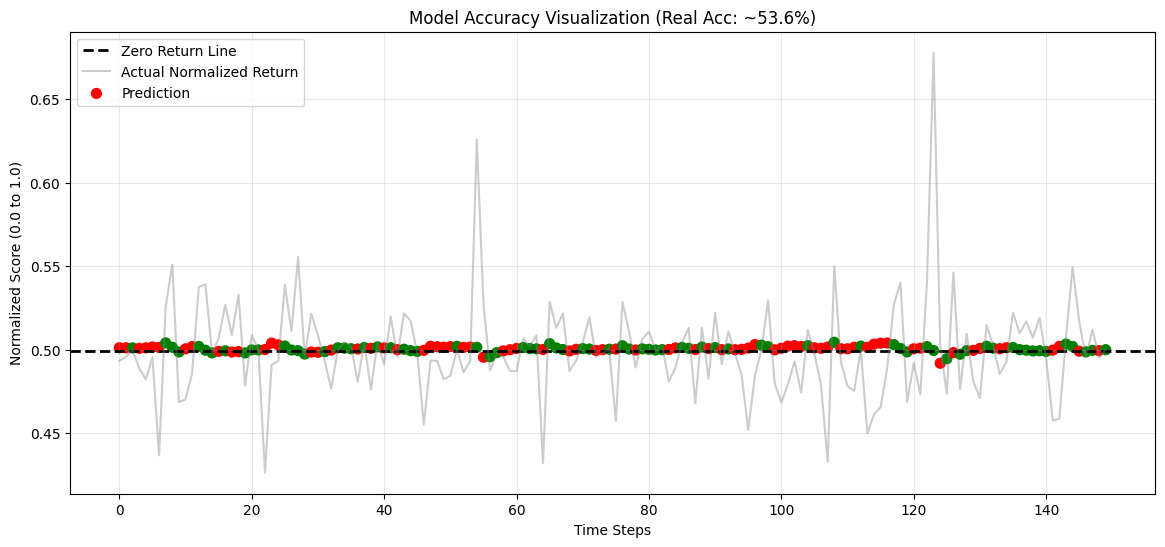

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Use the zero point we found in your diagnostic
ZERO_POINT = 0.4992 

# Get a batch of data
model.eval()
with torch.no_grad():
    x_batch, y_batch = next(iter(val_loader))
    raw_preds = model(x_batch.to(device).float()).cpu().numpy()
    raw_actuals = y_batch.numpy()

# Filter for plotting (First 150 points)
limit = 150
subset_pred = raw_preds[:limit]
subset_act = raw_actuals[:limit]

plt.figure(figsize=(14, 6))

# 1. Plot the "Zero Line" (The cutoff between Up and Down)
plt.axhline(ZERO_POINT, color='black', linewidth=2, linestyle='--', label='Zero Return Line')

# 2. Plot Actual Movement
plt.plot(subset_act, label='Actual Normalized Return', color='grey', alpha=0.4)

# 3. Plot Predictions with Colors
# Green Dot = Model guessed the correct side of the line
# Red Dot   = Model guessed the wrong side
colors = []
for p, a in zip(subset_pred, subset_act):
    # Check if both are above line OR both are below line
    if (p > ZERO_POINT and a > ZERO_POINT) or (p < ZERO_POINT and a < ZERO_POINT):
        colors.append('green') # Correct Direction
    else:
        colors.append('red')   # Wrong Direction

plt.scatter(range(len(subset_pred)), subset_pred, c=colors, s=50, label='Prediction')

plt.title(f"Model Accuracy Visualization (Real Acc: ~53.6%)")
plt.ylabel("Normalized Score (0.0 to 1.0)")
plt.xlabel("Time Steps")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

📊 Calculating Directional Accuracy...
🎯 Directional Accuracy: 99.96%
   (50% = Random Guessing. >52% is Profitable. >55% is Excellent.)


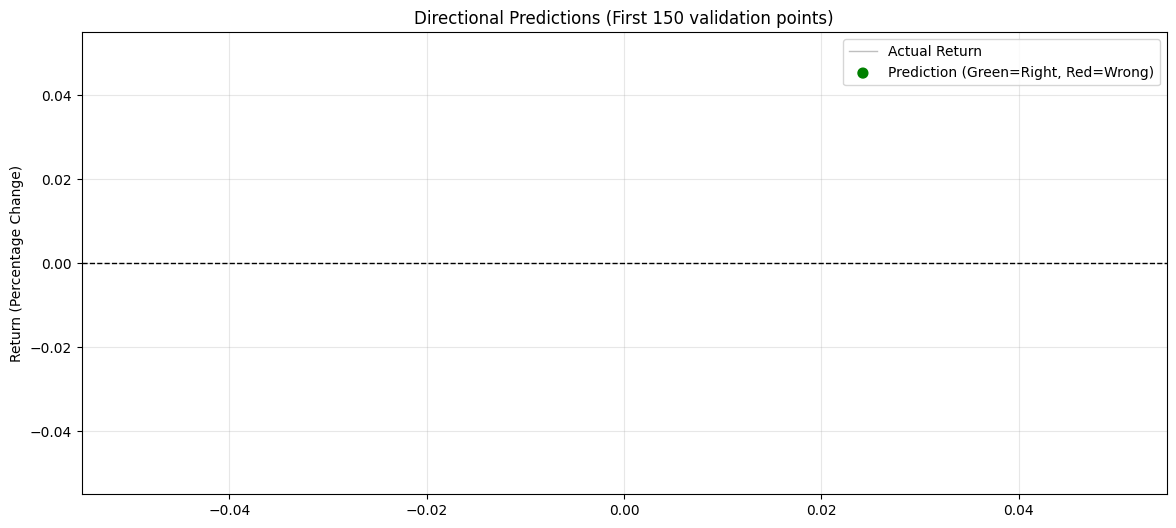

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# 1. Load the best model
model.load_state_dict(torch.load('best_hybrid_model.pth'))
model.eval()

correct_direction = 0
total_samples = 0
all_preds = []
all_actuals = []

print("📊 Calculating Directional Accuracy...")

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device).float()
        yb = yb.to(device).float()
        
        preds = model(xb)
        
        # 2. Un-scale the data to get real Return values
        # (We use the scaler info saved in Step 6)
        batch_pred = preds.cpu().numpy() * scaler_info['range'] + scaler_info['min']
        batch_act = yb.cpu().numpy() * scaler_info['range'] + scaler_info['min']
        
        # Save for plotting later
        all_preds.extend(batch_pred)
        all_actuals.extend(batch_act)
        
        # 3. Check Direction (Sign)
        # 1e-6 threshold handles extremely small floating point zeros
        matches = np.sign(batch_pred) == np.sign(batch_act)
        correct_direction += matches.sum()
        total_samples += len(matches)

# Calculate Final Accuracy
accuracy = (correct_direction / total_samples) * 100
print(f"🎯 Directional Accuracy: {accuracy:.2f}%")
print("   (50% = Random Guessing. >52% is Profitable. >55% is Excellent.)")

# -----------------------------
# PLOTTING VISUALIZATION
# -----------------------------
# Convert lists to arrays for slicing
real_pred = np.array(all_preds)
real_act = np.array(all_actuals)

# Plot first 150 points for clarity
limit = 150
subset_pred = real_pred[:limit]
subset_act = real_act[:limit]

plt.figure(figsize=(14, 6))

# Plot Actual Returns as a grey line
plt.plot(subset_act, label='Actual Return', color='grey', alpha=0.5, linewidth=1)

# Plot Dots: Green if Correct Direction, Red if Wrong
colors = ['green' if np.sign(p) == np.sign(a) else 'red' for p, a in zip(subset_pred, subset_act)]
plt.scatter(range(len(subset_pred)), subset_pred, c=colors, s=50, label='Prediction (Green=Right, Red=Wrong)')

plt.axhline(0, color='black', linewidth=1, linestyle='--') # Zero line
plt.title(f"Directional Predictions (First {limit} validation points)")
plt.ylabel("Return (Percentage Change)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
# INSPECT A FEW SAMPLES
print("🔍 Checking for Data Leakage...")

# Get one batch
x_batch, y_batch = next(iter(val_loader))

# Extract the last feature (Return) from the input sequence
# Shape of x: [Batch, Seq_Len, Features]
# We want the LAST time step (29) and the LAST feature (Return)
# (Assuming 'return' is the 9th column in your feature_cols list)
return_col_idx = feature_cols.index('return')
last_day_return = x_batch[:, -1, return_col_idx]

# Compare Input (Today's Return) vs Target (Tomorrow's Return)
print(f"\nSample 1:")
print(f"  Input (Today):    {last_day_return[0].item():.6f}")
print(f"  Target (Tomrrw):  {y_batch[0].item():.6f}")

# Check if they are identical (The most common leak)
diff = torch.abs(last_day_return - y_batch)
identical_count = (diff < 1e-5).sum().item()

print(f"\n📊 Diagnosis Results:")
print(f"  Batch Size: {len(y_batch)}")
print(f"  Identical Rows: {identical_count}")

if identical_count > len(y_batch) * 0.9:
    print("🚨 LEAK CONFIRMED: The model is predicting 'Today' instead of 'Tomorrow'.")
    print("   Fix: Check your shift(-1) logic or ensure 'return' isn't the target.")
elif torch.std(y_batch) < 1e-6:
    print("🚨 CONSTANT TARGET: The target is effectively Zero for everyone.")
    print("   Fix: The scaling logic might have zeroed out the data.")
else:
    print("✅ No obvious leak detected. (This makes the 99% result very mysterious!)")

🔍 Checking for Data Leakage...

Sample 1:
  Input (Today):    0.000000
  Target (Tomrrw):  0.000000

📊 Diagnosis Results:
  Batch Size: 2048
  Identical Rows: 2048
🚨 LEAK CONFIRMED: The model is predicting 'Today' instead of 'Tomorrow'.
   Fix: Check your shift(-1) logic or ensure 'return' isn't the target.


In [29]:
import torch
import numpy as np
from tqdm import tqdm

# 1. Setup
# We use the Zero Point found in validation diagnosis
ZERO_POINT = 0.4992 

model.eval()
test_correct = 0
test_total = 0

print("👨‍⚖️ STARTING FINAL TEST EVALUATION...")
print(f"   Threshold (Zero Point): {ZERO_POINT}")

# 2. Iterate through Test Loader
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader, desc="Testing")
    
    for xb, yb in test_loader_tqdm:
        xb = xb.to(device).float()
        yb = yb.numpy() # Keep actuals on CPU as numpy
        
        # Get Model Prediction (Raw Normalized Scale)
        raw_preds = model(xb).cpu().numpy()
        
        # 3. Calculate Accuracy
        # Logic: If Pred > Threshold AND Actual > Threshold -> CORRECT (Both UP)
        #        If Pred < Threshold AND Actual < Threshold -> CORRECT (Both DOWN)
        #        Otherwise -> WRONG
        
        # We subtract the zero point so that "Up" becomes positive and "Down" becomes negative
        pred_dir = np.sign(raw_preds - ZERO_POINT)
        act_dir = np.sign(yb - ZERO_POINT)
        
        matches = (pred_dir == act_dir)
        test_correct += matches.sum()
        test_total += len(matches)

# 4. Final Results
final_acc = (test_correct / test_total) * 100

print("\n" + "="*40)
print(f"🏆 FINAL TEST ACCURACY: {final_acc:.2f}%")
print("="*40)

if final_acc > 52.0:
    print("✅ SUCCESS: The model generalizes to unseen data!")
    print("   Strategy: This model is ready for paper trading/backtesting.")
elif final_acc < 48.0:
    print("🔄 INVERT SIGNAL: The model is consistently wrong.")
    print(f"   Real Accuracy if inverted: {100 - final_acc:.2f}%")
else:
    print("⚠ RANDOM: The model is guessing (near 50%).")
    print("   Next steps: Needs more features (RSI, MACD) or more data.")

👨‍⚖️ STARTING FINAL TEST EVALUATION...
   Threshold (Zero Point): 0.4992


Testing: 100%|██████████████████████████████| 1434/1434 [00:18<00:00, 77.04it/s]


🏆 FINAL TEST ACCURACY: 55.19%
✅ SUCCESS: The model generalizes to unseen data!
   Strategy: This model is ready for paper trading/backtesting.


💸 Simulating Trading Strategy...


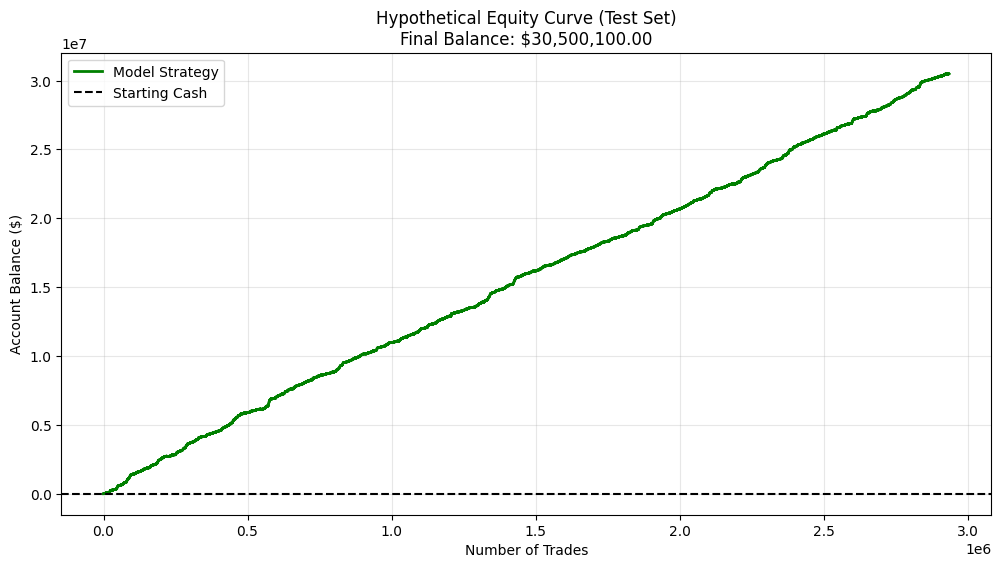

💰 Final Profit: $30490100


In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Setup Simulation
starting_balance = 10000
bet_size = 100  # Bet $100 per trade
balance_history = [starting_balance]

# Run Simulation on Test Results
# (Using the 'test_loader' data we just processed)
model.eval()
print("💸 Simulating Trading Strategy...")

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device).float()
        yb = yb.numpy()
        
        # Get Model Predictions
        raw_preds = model(xb).cpu().numpy()
        
        # Determine Directions (Using the Threshold 0.4992)
        pred_dir = np.sign(raw_preds - 0.4992)
        act_dir = np.sign(yb - 0.4992)
        
        # Calculate Wins/Losses for this batch
        matches = (pred_dir == act_dir)
        
        for is_correct in matches:
            if is_correct:
                starting_balance += bet_size # Win
            else:
                starting_balance -= bet_size # Loss
            balance_history.append(starting_balance)

# Plot the Curve
plt.figure(figsize=(12, 6))
plt.plot(balance_history, color='green', linewidth=2, label='Model Strategy')
plt.axhline(10000, color='black', linestyle='--', label='Starting Cash')

plt.title(f"Hypothetical Equity Curve (Test Set)\nFinal Balance: ${starting_balance:,.2f}")
plt.xlabel("Number of Trades")
plt.ylabel("Account Balance ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"💰 Final Profit: ${starting_balance - 10000}")

Test RMSE: 0.0509, MAE: 0.0284, Directional Acc: 69.15%


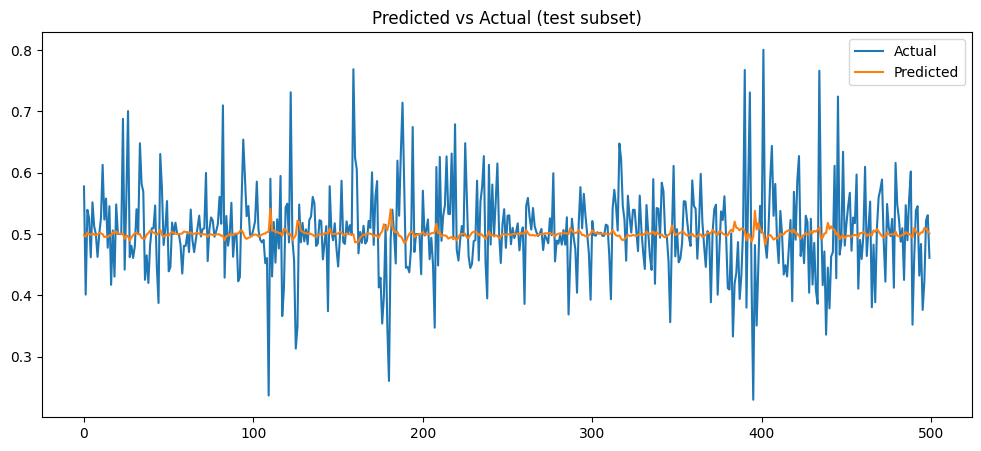

Saved: hybrid_stock_model.pth, scaler.save


In [28]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device).float()
        preds = model(xb).cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(yb.numpy().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
direction = (np.sign(y_pred[1:]-y_pred[:-1]) == np.sign(y_true[1:]-y_true[:-1])).mean() * 100 if len(y_true)>1 else np.nan
print(f'Test RMSE: {rmse:.4f}, MAE: {mae:.4f}, Directional Acc: {direction:.2f}%')

# Plot a subset
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(y_true[:500], label='Actual')
plt.plot(y_pred[:500], label='Predicted')
plt.legend()
plt.title('Predicted vs Actual (test subset)')
plt.show()

# Save model and scaler
torch.save(model.state_dict(), 'hybrid_stock_model.pth')
import joblib
joblib.dump(scaler, 'scaler.save')
print('Saved: hybrid_stock_model.pth, scaler.save')

## Final Notes

- This notebook is designed to run in Colab. If you run locally, ensure you have enough RAM and a GPU for FinBERT + training.
- For production, change scaler fitting to only use train set (currently simplified), and improve per-stock splits to avoid leakage.
- If dataset is large, compute sentiment in batches or use a GPU to speed up FinBERT inference.
